# Satellite Data Polar Cartopy Plot Example

This example demonstrates requesting MUR SST satellite from the PolarWatch ERDDAP and then plotting the data in polar projection with cartopy. 

In [22]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import urllib3 
import cartopy
import cartopy.crs as ccrs
import os
import dateutil.parser
from dateutil.relativedelta import *
from datetime import datetime, timedelta

# Make a data request from ERDDAP

Here we define a data request with a dataset ID, the variable to download and the time stamp to download. We use this info to form our data request.

MUR SST is a high-resolution global dataset so here we select one time stamp and subset the data to get only data in the Southern ocean and only get every 100th cell to minimize the size of the data request.

Note that datasets in ERDDAP may for may not have an altitude dimension. 
An altitude request is required if the dataset includes an altidude dimension.
Here is example formatting of a request with altitude:

query = param +'[(%s):%s:(%s)][(%s):%s:(%s)][(%f):%s:(%f)][(%f):%s:(%f)]' % (timestart,timesub,timeend,altMin,altsub, altMax,lat1,latsub,lat2,minlon,lonsub,maxlon)


In [23]:


# define dataset, parameter and time for data request
datasetId = 'jplMURSST41'
param = 'analysed_sst'
time = '2018-03-07T09:00:00Z'

# Define area for data request 
# from -50 degrees to the south pole, reducing data request latutudinal resolution by a factor of 100
lat1 = -89.99
lat2 = -60
# Get all longitudes
lon1 = -179.99
lon2 = 180.00

base_url = 'https://polarwatch.noaa.gov/erddap/griddap/'+ datasetId +'.nc?'

timeQuery = '[(%s):%s:(%s)]' % (time,'1',time)

latQuery  = '[(%s):%s:(%s)]' % (lat1,'100',lat2)

lonQuery  = '[(%s):%s:(%s)]' % (lon1,'100',lon2)

query = param + timeQuery + latQuery + lonQuery

requestUrl = base_url + query

print('NetCDF Request URL: ' + requestUrl)

NetCDF Request URL: https://polarwatch.noaa.gov/erddap/griddap/jplMURSST41.nc?analysed_sst[(2018-03-07T09:00:00Z):1:(2018-03-07T09:00:00Z)][(-89.99):100:(-60)][(-179.99):100:(180.0)]


# Request the data from ERDDAP

In [24]:
# Filename and location to store the requested data
file = 'dataset.nc'

http = urllib3.PoolManager()
r = http.request('GET', requestUrl, preload_content=False)

with open(file, 'wb') as out:
    while True:
        data = r.read(1024*1024)
        if not data:
            break
        out.write(data)

r.release_conn()

# netcdf data object
dataset = netcdf_dataset(file)

print('NetCDF file retrieved')

NetCDF file retrieved


# Open NetCDF and load data for plotting

In [25]:
data = dataset.variables[param][0, :, :]
lats = dataset.variables['latitude'][:]
lons = dataset.variables['longitude'][:]

# Make a polar projected plot using cartopy

Next we will demonstrate how to plot the data on a polar stereographic map using cartopy.

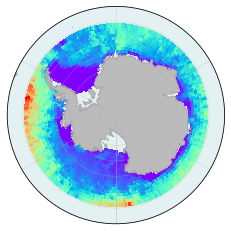

In [26]:
fig = plt.figure()    

# Set area ouside of circle to transparent
fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0.0)

ax1 = plt.axes(projection = ccrs.SouthPolarStereo() )
ax1.set_global()

# Compute a circle in axes coordinates, to use as a boundary for the map.
theta = np.linspace( 0, 2 * np.pi, 100 )
center, radius = [0.5, 0.5], 0.5
verts = np.vstack( [np.sin(theta), np.cos(theta)] ).T
circle = mpath.Path( verts * radius + center )
ax1.set_boundary( circle, transform = ax1.transAxes)

# set plot background color (water)
ax1.set_facecolor('#e4f1f2')

# get data limits
vmaxData = np.amax(data)
vminData = np.amin(data)

colormap = 'rainbow'

dataplt = ax1.pcolormesh(
    lons,
    lats,
    data,
    vmin=vminData,
    cmap=colormap,
    vmax=vmaxData,
    transform=ccrs.PlateCarree()
)

# reduce equatorward extent of plot
ax1.set_extent([-4000000, 4000000, -4000000, 4000000], ccrs.SouthPolarStereo())

# Add Land
ax1.add_feature( cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='#bbbbbb') 

# Add coastline
ax1.coastlines(color='#aaaaaa')

# Add lat lon rings
ax1.gridlines(alpha=0.3)

plt.show()
      